In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("facet-terms-for-082a_ClassificationDdc.csv")

In [3]:
df.describe(include='all')

,term,count
count,45487,45487.000000
unique,45487,NaN
top,2,NaN
freq,1,NaN
mean,NaN,9.490734
std,NaN,95.892351
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,2.000000


It is visible from the above stats that there are 45487 rows of data which are all unique.

In [4]:
df_simple_term_resolution = pd.read_csv("combined_output.csv")

In [5]:
non_null_count = df_simple_term_resolution['Returned List'].notnull().sum()
total_count = len(df)
percentage_non_null = (non_null_count / total_count) * 100

print(f"Percentage of terms with values in 'Returned List': {percentage_non_null:.2f}%")


Percentage of terms with values in 'Returned List': 100.00%


All the rows have returned values which means API returned some response for all the rows.

In [6]:
valid_responses = df_simple_term_resolution['Returned List'].apply(lambda x: x != '[]' and pd.notnull(x))

valid_count = valid_responses.sum()

empty_count = (~valid_responses).sum()

total_count = len(df)


print(f"Total rows: {total_count}")
print(f"Number of rows with valid responses: {valid_count}")
print(f"Number of rows with empty lists: {empty_count}")


percentage_valid = (valid_count / total_count) * 100
percentage_empty = (empty_count / total_count) * 100

print(f"Percentage of rows with valid responses: {percentage_valid:.2f}%")
print(f"Percentage of rows with empty lists: {percentage_empty:.2f}%")

Total rows: 45487
Number of rows with valid responses: 10725
Number of rows with empty lists: 40465
Percentage of rows with valid responses: 23.58%
Percentage of rows with empty lists: 88.96%


The above stats show us that 23.58% of terms were resolved using the first API while 76.42% of terms were not resolved.


Number of simple resolved terms: 10725

Now lets load and analyze the data after finding the gap for valid terms after first API

In [7]:
df_with_gap= pd.read_csv("combined_output_with_gap.csv")
df_with_valid_reponse_from_API= df_simple_term_resolution[df_simple_term_resolution['Returned List'].apply(lambda x: len(str(x))>20)]

Merging these two dataframes to find out percentage of valid terms with gap.

In [8]:
df_with_valid_reponse_from_API['term'] = df_with_valid_reponse_from_API['term'].astype(str)
df_with_gap['term'] = df_with_gap['term'].astype(str)

/tmp/ipykernel_213947/1664961194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_valid_reponse_from_API['term'] = df_with_valid_reponse_from_API['term'].astype(str)


In [9]:
df_with_gap_unique = df_with_gap.drop_duplicates(subset='term')


In [10]:
df_merged_for_gap= pd.merge(df_with_valid_reponse_from_API, df_with_gap_unique[['term', 'HasGap']], on='term', how='left')

In [11]:
count_values = df_merged_for_gap['HasGap'].value_counts()
percentage_values = df_merged_for_gap['HasGap'].value_counts(normalize=True) * 100
results = pd.DataFrame({
    'Count': count_values,
    'Percentage': percentage_values
})

print(results)

        Count  Percentage
HasGap                   
False    6396   66.266059
True     3256   33.733941


There for 66.37% of valid terms after the first API resolution didn't have the gap while 33.73 has the gap.

Know lets move onto the second API that also resolves the complex terms from the auxilary tables.

Lets load the data after resolving the unresolved terms from the simple API using complex API.

In [12]:
df_complex_term_resolution= pd.read_csv("combined_output_with_new_API.csv")

In [13]:
df_complex_resolved_terms= df_complex_term_resolution[df_complex_term_resolution['Returned from second API'].apply(lambda x: len(str(x))>20)]

We can see that 19898 terms are complex resolved terms which means that these terms existed in auxilary tables that is why first API could not resolve these terms but second API could resolve these terms.


<center>
<h2><b>Overall results:</b></h2>
<h3><b>Total number of terms: 45487</b></h3>
<h3><b>Simple resolved terms: 10725 (23.58%)</b></h3>
<h3><b>Complex resolved terms: 19898 (43.75%)</b></h3>
<h3><b>Total resolved terms: 30623 (67.33%)</b></h3>
<h3><b>Invalid terms: 14864 (32.67%)</b></h3>
</center>


In [14]:
import re
def get_dewey_number_from_built_number(response_from_API):
    regex_pattern= "notation\':\s*\[\'([0-9.]+)\'"
    matches = re.finditer(regex_pattern, response_from_API)
    matches = [match.group(1) for match in matches]
    
    longest_string = max(matches, key=len)
    return longest_string

In [21]:
df_with_valid_reponse_from_API["lenth_of_dewey_numbers"]= df_with_valid_reponse_from_API["term"].apply(lambda x: len(str(x).replace('.', '')))


/tmp/ipykernel_213947/4039272662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_valid_reponse_from_API["lenth_of_dewey_numbers"]= df_with_valid_reponse_from_API["term"].apply(lambda x: len(str(x).replace('.', '')))


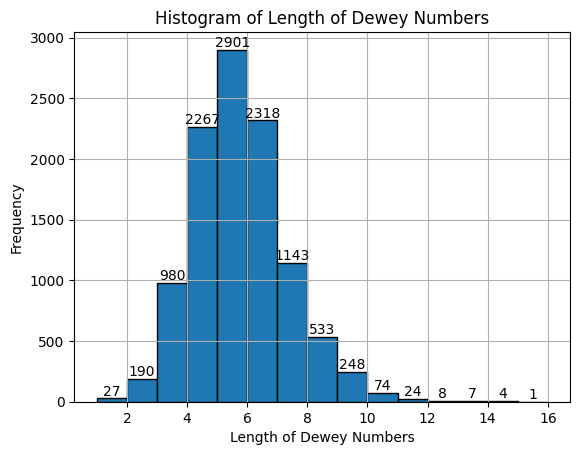

In [22]:

import matplotlib.pyplot as plt

# Plot histogram
counts, bins, _= plt.hist(df_with_valid_reponse_from_API['lenth_of_dewey_numbers'], bins=range(min(df_with_valid_reponse_from_API['lenth_of_dewey_numbers']), max(df_with_valid_reponse_from_API['lenth_of_dewey_numbers']) + 2, 1), edgecolor='black')
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count + 0.5, int(count), ha='center', va='bottom', fontsize=10)
plt.xlabel('Length of Dewey Numbers')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Dewey Numbers')
plt.grid(True)
plt.show()

It is vissible from the length of dewey numbers histogram for the simple terms that most terms comes from the hirarchy level of 6.

In [15]:
df_complex_resolved_terms["dewey_numbers_from_API_response"]= df_complex_resolved_terms["Returned from second API"].apply(get_dewey_number_from_built_number)

/tmp/ipykernel_213947/3602802511.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complex_resolved_terms["dewey_numbers_from_API_response"]= df_complex_resolved_terms["Returned from second API"].apply(get_dewey_number_from_built_number)


In [16]:
df_complex_resolved_terms["lenth_of_dewey_numbers"]= df_complex_resolved_terms["dewey_numbers_from_API_response"].apply(lambda x: len(str(x).replace('.', '')))

/tmp/ipykernel_213947/4124090445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complex_resolved_terms["lenth_of_dewey_numbers"]= df_complex_resolved_terms["dewey_numbers_from_API_response"].apply(lambda x: len(str(x).replace('.', '')))


In [17]:
# df_complex_resolved_terms.to_csv("combined_output_with_new_API_with_dewey_numbers_and_count.csv")
# df_complex_resolved_terms= pd.read_csv("combined_output_with_new_API_with_dewey_numbers_and_count.csv")

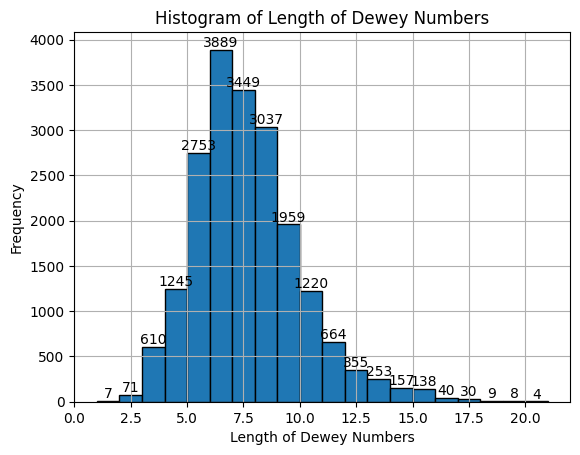

In [26]:
# Plot histogram
counts, bins, _= plt.hist(df_complex_resolved_terms['lenth_of_dewey_numbers'], bins=range(min(df_complex_resolved_terms['lenth_of_dewey_numbers']), max(df_complex_resolved_terms['lenth_of_dewey_numbers']) + 2, 1), edgecolor='black')
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count + 0.5, int(count), ha='center', va='bottom', fontsize=10)
plt.xlabel('Length of Dewey Numbers')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Dewey Numbers')
plt.grid(True)
plt.show()

It is vissible from the length of dewey numbers extracted from build number histogram that most terms comes from the hirarchy level of 6.

In [23]:
all_dewey_terms_length=pd.concat([df_complex_resolved_terms['lenth_of_dewey_numbers'], df_with_valid_reponse_from_API['lenth_of_dewey_numbers']])

all_dewey_terms_length = all_dewey_terms_length.reset_index(drop=True)

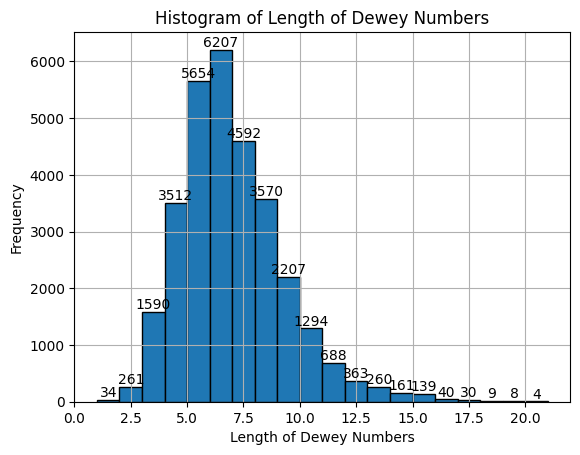

In [25]:
counts, bins, _= plt.hist(all_dewey_terms_length, bins=range(min(all_dewey_terms_length), max(all_dewey_terms_length) + 2, 1), edgecolor='black')
for count, bin_edge in zip(counts, bins[:-1]):
    plt.text(bin_edge + 0.5, count + 0.5, int(count), ha='center', va='bottom', fontsize=10)
plt.xlabel('Length of Dewey Numbers')
plt.ylabel('Frequency')
plt.title('Histogram of Length of Dewey Numbers')
plt.grid(True)
plt.show()

It is vissible from the length of dewey numbers histogram for the simple terms that most terms comes from the hirarchy level of 6.